In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils.utils import bspline,mad

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# PDB
import pdb # pdb.set_trace()

# TQDM
from tqdm.notebook import tqdm

In [2]:
import MagellanicStream as MagellanicStream

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def extcoeff(wavelength,rv=3.1,law='CCM89'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    ext_coeff = ext_model(wavelength*u.micron)/ext_model(0.6419*u.micron)
    
    return ext_coeff

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']
# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

# APOGEE

In [4]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [5]:
from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

In [7]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [8]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

In [9]:
agetab = fits.getdata('lmc_dr17_lm_calteff_31AUG2022.fits')

0.48611552

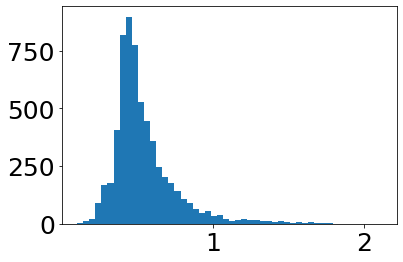

In [10]:
plt.hist(salfeh_err,bins=50)

np.nanmedian(salfeh_err)

# Isochrone Check

In [11]:
def isocheck(teff,logg,feh,isochrones):
    '''
    Check if a star is on an isochrone within uncertainty
    
    Inputs:
    ------
        teff: 2x1 array-like
              teff and error
        
        logg: 2x1 array-like
              logg and error
        
        feh:  float
              Ideally Salaris corrected metallicity
    
    '''
    
    # Teff values
    teff_lo = np.log10(teff[0]-teff[1])
    teff_hi = np.log10(teff[0]+teff[1])
    
    # logg values
    logg_val = logg[0]
    logg_unc = logg[0]
    
    ### metallicity check
    if np.isfinite(feh) == False:
        feh_flag = 'NaN'
    
    elif feh < min(isochrones['MH']):
        feh_flag = 'LOW'
    
    elif feh > max(isochrones['MH']):
        feh_flag = 'HIGH'
        
    elif feh > min(isochrones['MH']) and feh < max(isochrones['MH']):
        feh_flag = 'NONE'
        
    # Pick all isochrone with the same metallicity
    iso_feh = isochrones[np.where(isochrones['MH']==closest(isochrones['MH'],feh))]
    
    ### teff check
    if np.isfinite(teff[0]) == False:
        teff_flag = 'NaN'
    
    elif teff_lo < min(iso_feh['logTe']):
        teff_flag = 'LOW'
        
    elif teff_hi > max(iso_feh['logTe']):
        teff_flag = 'HIGH'
        
    elif (np.log10(teff[0]) > min(iso_feh['logTe'])) and (np.log10(teff[0]) < max(iso_feh['logTe'])):
        teff_flag = 'NONE'
    
    ### logg check
    if np.isfinite(logg_val) == False:
        teff_flag = 'NaN'
    
    elif logg_val < min(iso_feh['logg'])-logg_unc:
        logg_flag = 'LOW'
        
    elif logg_val > max(iso_feh['logg'])+logg_unc:
        logg_flag = 'HIGH'
        
    elif (logg_val > min(iso_feh['logg'])-logg_unc) and (logg_val < max(iso_feh['logg'])+logg_unc):
        logg_flag = 'NONE'
    
    return teff_flag ,logg_flag, feh_flag

In [12]:
lmc_teff_flag = np.array([])
lmc_logg_flag = np.array([])
lmc_feh_flag = np.array([])

iso_lite = massive['MH','logTe','logg']

for i in tqdm(range(len(lmcdr17))):
    te = np.array([lmcdr17['TEFF'][i],lmcdr17['TEFF_ERR'][i]])
    lg = np.array([lmcdr17['LOGG'][i],lmcdr17['LOGG_ERR'][i]])
    fe = salfeh[i]
    
    tf_flag, lg_flag, fe_flag = isocheck(te,lg,fe,iso_lite)
    
    lmc_teff_flag = np.append(lmc_teff_flag,tf_flag)
    lmc_logg_flag = np.append(lmc_logg_flag,lg_flag)
    lmc_feh_flag = np.append(lmc_feh_flag,fe_flag)

  0%|          | 0/6130 [00:00<?, ?it/s]

In [16]:
from astropy.table import Table, Column

cname = Column(lmcdr17['APOGEE_ID'], name='NAME')
cteff_flag = Column(lmc_teff_flag,name='TEFF_FLAG')
clogg_flag = Column(lmc_logg_flag,name='LOGG_FLAG')
cfeh_flag = Column(lmc_feh_flag,name='FE_H_FLAG')

flagtable = Table([cname,cteff_flag,clogg_flag,cfeh_flag])
flagtable.write('lmc_dr17_parsec3_6_flags.fits',format='fits', overwrite=True)

In [19]:
test = fits.getdata('lmc_dr17_parsec3_6_flags.fits')
Table(test)

NAME,TEFF_FLAG,LOGG_FLAG,FE_H_FLAG
str18,str32,str32,str32
2M05135760-6927482,NONE,NONE,NONE
2M05141412-6948281,NONE,NONE,NONE
2M05142479-6937219,NONE,NONE,NONE
2M05142566-7002167,NONE,NONE,NONE
2M05142642-6947430,NONE,NONE,NONE
2M05144718-6948425,NONE,NONE,NONE
2M05150833-6934212,NONE,NONE,NONE
2M05151027-6936382,NONE,NONE,NONE
2M05152010-6921178,NONE,NONE,NONE


In [40]:
len(np.where(lmc_feh_flag!='NONE')[0])

12

In [43]:
len(np.where(lmc_teff_flag!='NONE')[0])

91

In [44]:
len(np.where(lmc_logg_flag!='NONE')[0])

69

In [20]:
agetab = fits.getdata('lmc_dr17_lm_calteff_31AUG2022.fits')
agetab_asp = fits.getdata('lmc_dr17_lm_aspcap_24AUG2022.fits')
ygridage = np.where(agetab['AGE']==0.0)
ygridage

(array([   1,    2,    3,    4,   24,   25,   29,   33,   36,   38,   43,
          72,   83,   85,   87,   97,  112,  115,  122,  123,  130,  131,
         137,  142,  148,  157,  160,  162,  163,  171,  187,  196,  211,
         335,  346,  363,  376,  379,  396,  404,  431,  438,  440,  460,
         463,  467,  473,  474,  477,  478,  482,  489,  491,  502,  515,
         526,  527,  533,  546,  556,  560,  569,  572,  576,  578,  581,
         586,  587,  588,  591,  595,  603,  612,  618,  620,  640,  641,
         659,  665,  668,  679,  680,  687,  697,  705,  708,  709,  714,
         716,  735,  746,  750,  774,  777,  792,  797,  803,  809,  816,
         823,  827,  837,  846,  859,  860,  866,  870,  877,  883,  884,
         886,  892,  894,  901,  905,  913,  925,  929,  940,  948,  953,
         961,  970,  971,  984,  985,  987,  990,  994,  998, 1009, 1024,
        1032, 1040, 1046, 1052, 1057, 1074, 1107, 1113, 1119, 1137, 1138,
        1143, 1145, 1158, 1159, 1166, 

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


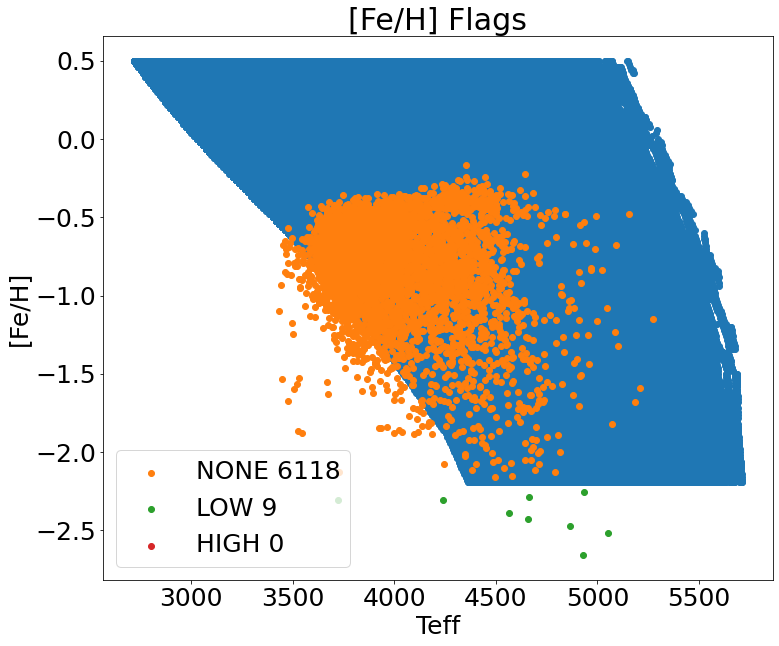

In [21]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['MH'])
# plt.scatter(teff_cal,salfeh)
plt.scatter(teff_cal[np.where(lmc_feh_flag=='NONE')],salfeh[np.where(lmc_feh_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_feh_flag=='LOW')],salfeh[np.where(lmc_feh_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_teff_flag=='HIGH')],salfeh[np.where(lmc_teff_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='HIGH')))))
plt.legend()
plt.title(r'[Fe/H] Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'[Fe/H]')
plt.show()

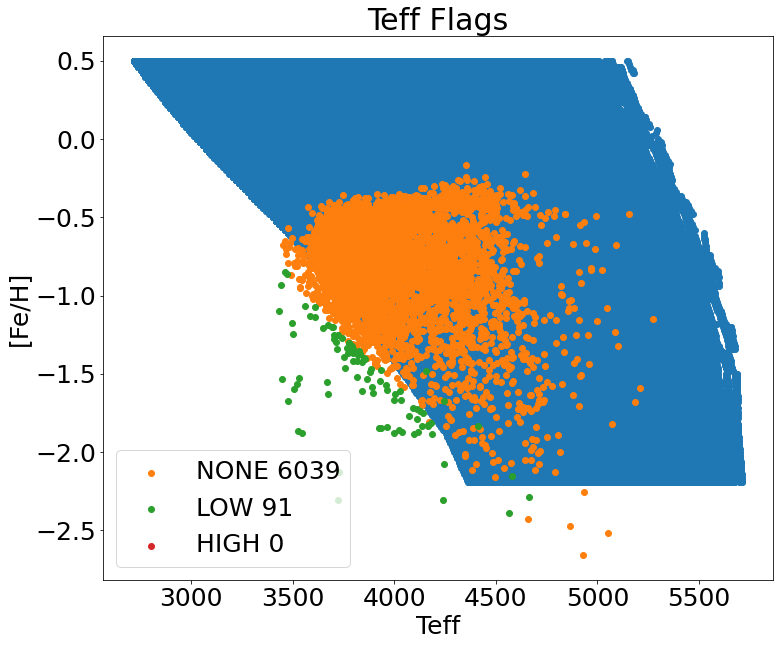

In [22]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['MH'])
# plt.scatter(teff_cal,salfeh)
plt.scatter(teff_cal[np.where(lmc_teff_flag=='NONE')],salfeh[np.where(lmc_teff_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_teff_flag=='LOW')],salfeh[np.where(lmc_teff_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_teff_flag=='HIGH')],salfeh[np.where(lmc_teff_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='HIGH')))))
plt.legend()
plt.title(r'Teff Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'[Fe/H]')
plt.show()

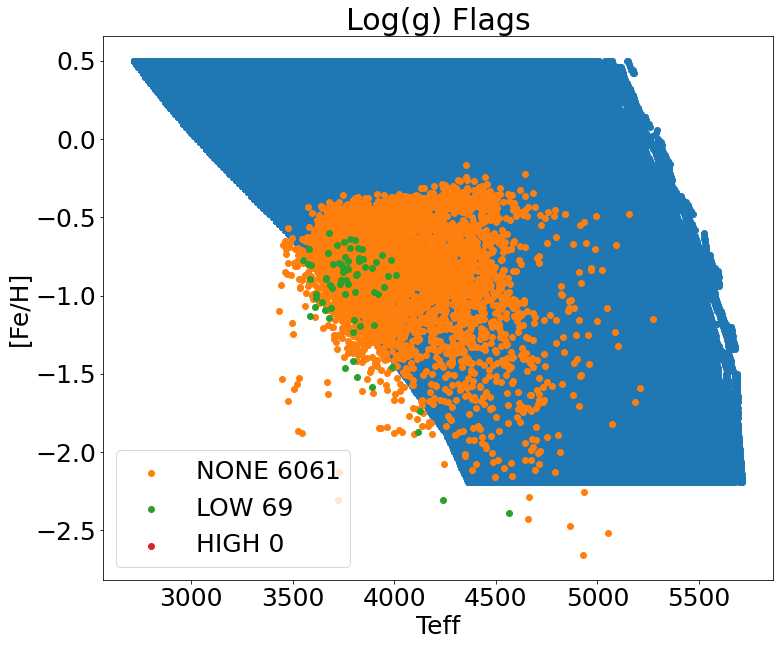

In [24]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['MH'])
# plt.scatter(teff_cal,salfeh)
plt.scatter(teff_cal[np.where(lmc_logg_flag=='NONE')],salfeh[np.where(lmc_logg_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_logg_flag=='LOW')],salfeh[np.where(lmc_logg_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_logg_flag=='HIGH')],salfeh[np.where(lmc_logg_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='HIGH')))))
plt.legend()
plt.title(r'Log(g) Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'[Fe/H]')
plt.show()

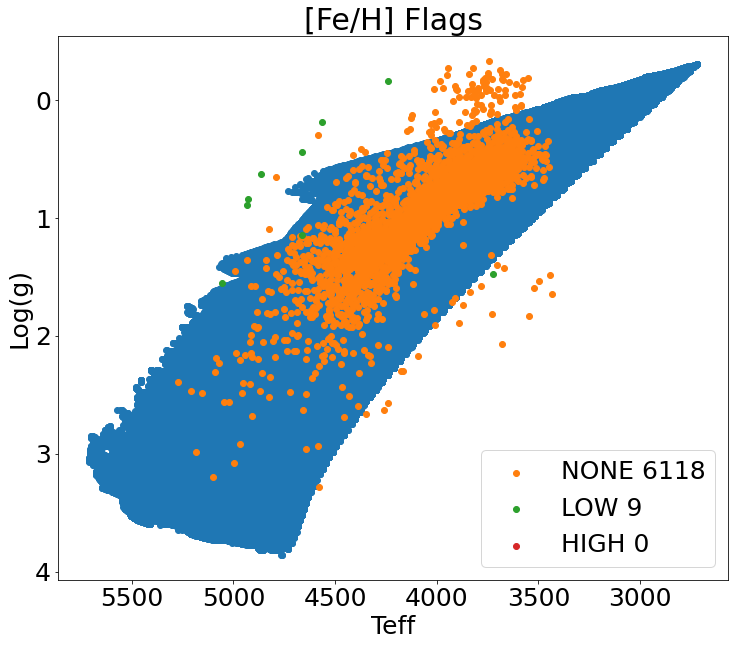

In [25]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'])
plt.scatter(teff_cal[np.where(lmc_feh_flag=='NONE')],lmcdr17['LOGG'][np.where(lmc_feh_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_feh_flag=='LOW')],lmcdr17['LOGG'][np.where(lmc_feh_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_feh_flag=='HIGH')],lmcdr17['LOGG'][np.where(lmc_feh_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_feh_flag=='HIGH')))))

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.legend()
plt.title(r'[Fe/H] Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

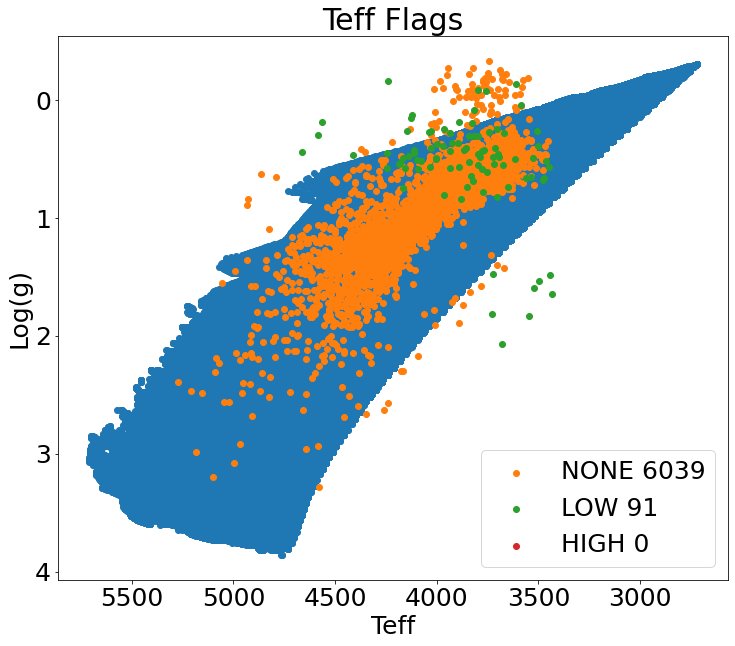

In [26]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'])
plt.scatter(teff_cal[np.where(lmc_teff_flag=='NONE')],lmcdr17['LOGG'][np.where(lmc_teff_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_teff_flag=='LOW')],lmcdr17['LOGG'][np.where(lmc_teff_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_teff_flag=='HIGH')],lmcdr17['LOGG'][np.where(lmc_teff_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_teff_flag=='HIGH')))))

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.legend()
plt.title(r'Teff Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

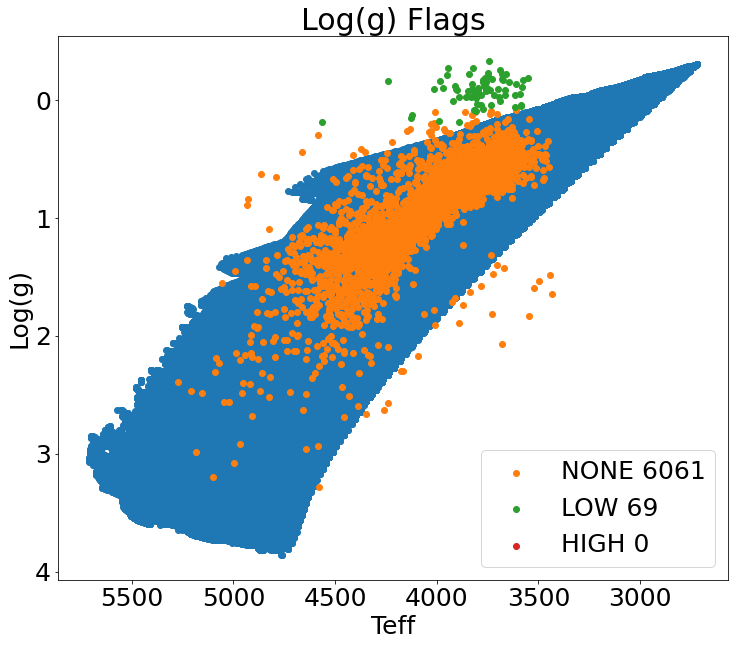

In [27]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'])
plt.scatter(teff_cal[np.where(lmc_logg_flag=='NONE')],lmcdr17['LOGG'][np.where(lmc_logg_flag=='NONE')],
            label='NONE {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='NONE')))))
plt.scatter(teff_cal[np.where(lmc_logg_flag=='LOW')],lmcdr17['LOGG'][np.where(lmc_logg_flag=='LOW')],
            label='LOW {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='LOW')))))
plt.scatter(teff_cal[np.where(lmc_logg_flag=='HIGH')],lmcdr17['LOGG'][np.where(lmc_logg_flag=='HIGH')],
            label='HIGH {}'.format(len(np.squeeze(np.where(lmc_logg_flag=='HIGH')))))

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.legend()
plt.title(r'Log(g) Flags')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

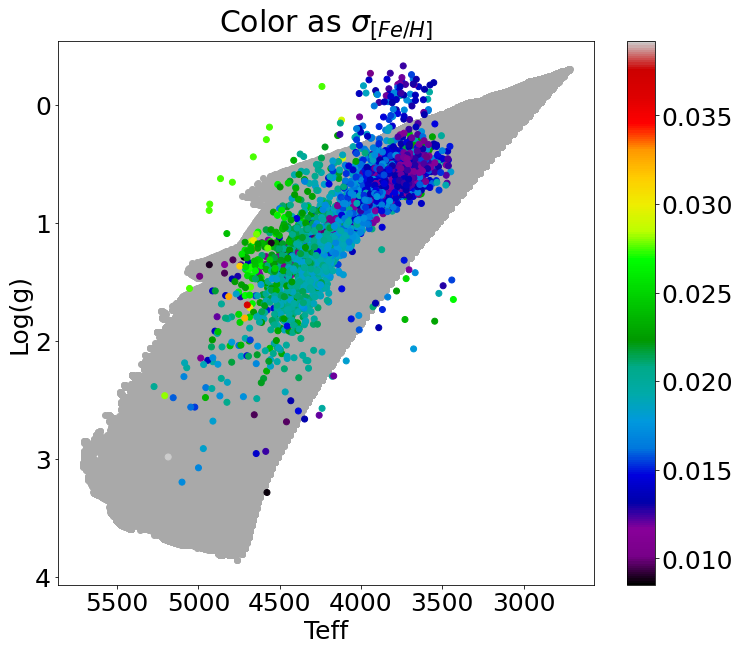

In [28]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'],c='darkgrey')
plt.scatter(teff_cal,lmcdr17['LOGG'],c=lmcdr17['FE_H_ERR'],cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as $\sigma_{[Fe/H]}$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

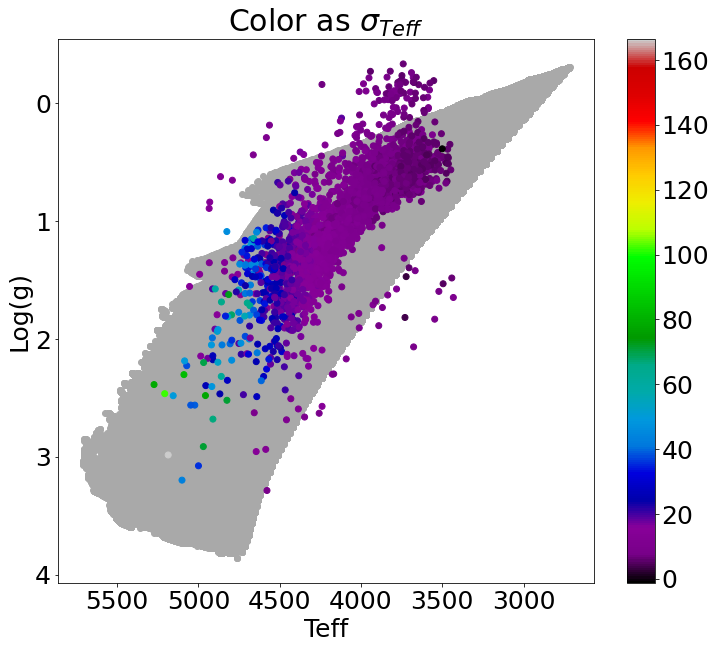

In [29]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'],c='darkgrey')
plt.scatter(teff_cal,lmcdr17['LOGG'],c=lmcdr17['TEFF_ERR'],cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as $\sigma_{Teff}$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

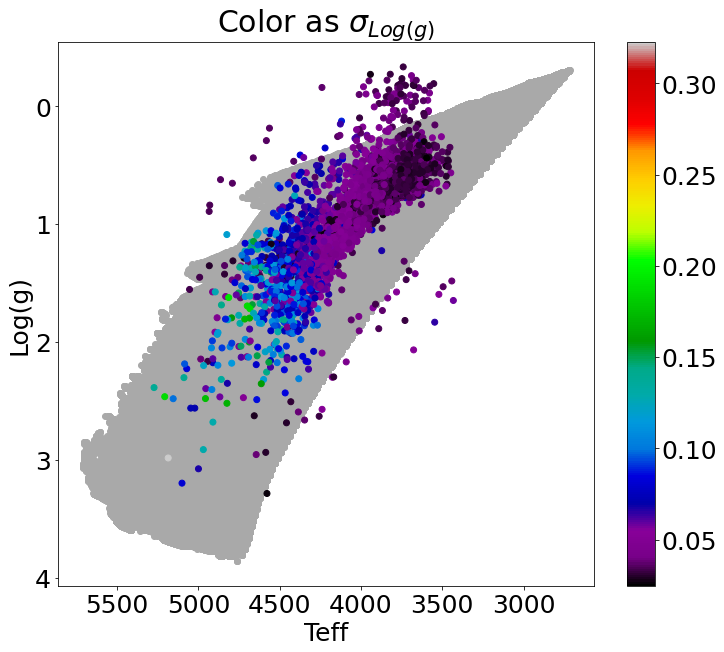

In [30]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'],massive['logg'],c='darkgrey')
plt.scatter(teff_cal,lmcdr17['LOGG'],c=lmcdr17['LOGG_ERR'],cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as $\sigma_{Log(g)}$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

In [31]:
not_none_feh = np.zeros(len(lmcdr17))
not_none_teff = np.zeros(len(lmcdr17))
not_none_logg = np.zeros(len(lmcdr17))

for i in range(len(lmcdr17)):
    if lmc_feh_flag[i] != 'NONE':
        not_none_feh[i] = 1
        
    if lmc_teff_flag[i] != 'NONE':
        not_none_teff[i] = 1
        
    if lmc_logg_flag[i] != 'NONE':
        not_none_logg[i] = 1
        
not_none_feh = list(np.squeeze(np.where(not_none_feh==1)))
not_none_teff = list(np.squeeze(np.where(not_none_teff==1)))
not_none_logg = list(np.squeeze(np.where(not_none_logg==1)))

not_none_all = not_none_feh + not_none_teff + not_none_logg
not_none_all = np.unique(np.array(not_none_all))

print('Total Bad Stars: ',len(not_none_all))

Total Bad Stars:  158


In [32]:
combinedflags = np.array([])

for i in range(len(lmcdr17)):
    combinedflags = np.append(combinedflags,'{}, {}, {}'.format(lmc_feh_flag[i],lmc_teff_flag[i],lmc_logg_flag[i]))

In [33]:
np.unique(combinedflags)

array(['LOW, LOW, LOW', 'LOW, LOW, NONE', 'LOW, NONE, NONE',
       'NONE, LOW, LOW', 'NONE, LOW, NONE', 'NONE, NONE, LOW',
       'NONE, NONE, NONE', 'NaN, NONE, NONE'], dtype='<U32')

In [34]:
badflags = np.array([])
goodflags = np.array([])

for i in range(len(lmcdr17)):
    if combinedflags[i] != 'NONE, NONE, NONE':
        badflags = np.append(badflags,i)
        
    if combinedflags[i] == 'NONE, NONE, NONE':
        goodflags = np.append(goodflags,i)
        
badflags = badflags.astype(int)
goodflags = goodflags.astype(int)

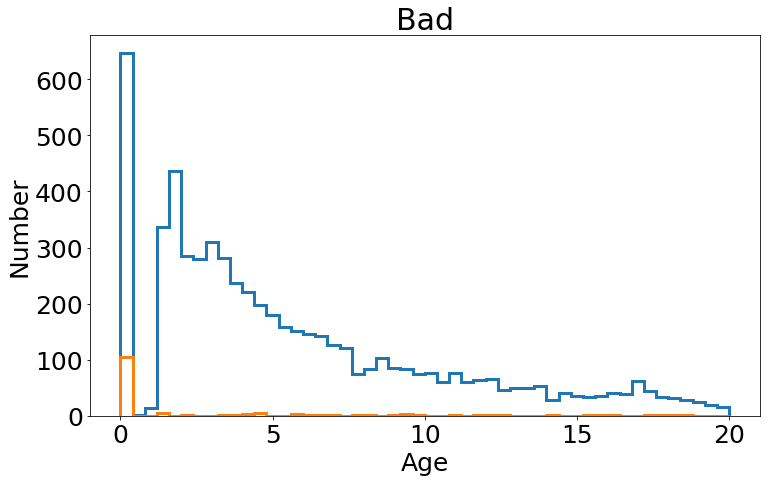

In [35]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],range=(0,20),bins=50,histtype='step',lw=3.0)
plt.hist(agetab['AGE'][badflags],range=(0,20),bins=50,histtype='step',lw=3.0)
plt.title(r'Bad')
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.show()

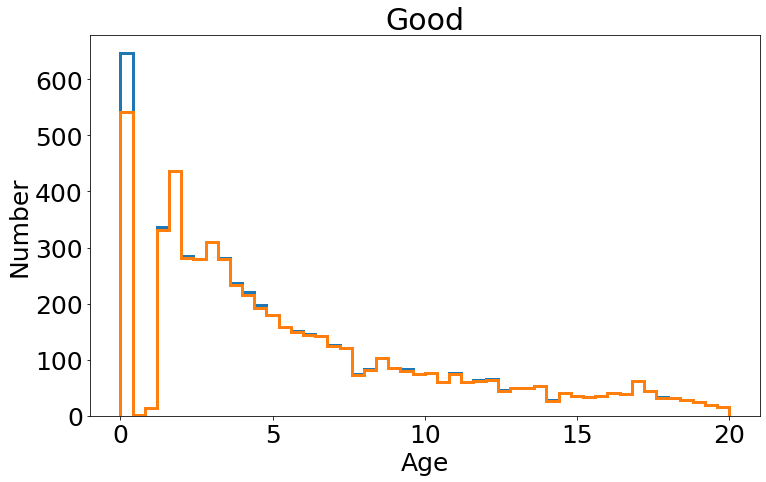

In [36]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],range=(0,20),bins=50,histtype='step',lw=3.0)
plt.hist(agetab['AGE'][goodflags],range=(0,20),bins=50,histtype='step',lw=3.0)
plt.title(r'Good')
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.show()

In [57]:
goodflags_badage = np.where(agetab['AGE'][goodflags]==0.0)

In [58]:
goodflags_badage

(array([   1,    2,    3,    4,   24,   25,   32,   35,   37,   42,   71,
          83,   94,  111,  118,  119,  126,  132,  142,  151,  154,  156,
         164,  180,  189,  204,  328,  339,  355,  370,  387,  395,  422,
         429,  431,  451,  454,  458,  464,  467,  468,  472,  501,  512,
         513,  531,  541,  545,  554,  557,  562,  565,  570,  571,  574,
         578,  594,  600,  621,  622,  640,  646,  649,  659,  660,  676,
         684,  686,  687,  692,  694,  723,  727,  751,  754,  773,  779,
         785,  792,  799,  803,  813,  822,  835,  836,  842,  846,  858,
         859,  861,  867,  875,  879,  887,  899,  903,  914,  933,  942,
         943,  956,  958,  961,  968,  979, 1001, 1014, 1023, 1040, 1073,
        1079, 1085, 1103, 1108, 1110, 1123, 1124, 1140, 1176, 1189, 1210,
        1228, 1247, 1272, 1273, 1274, 1286, 1287, 1291, 1292, 1315, 1317,
        1343, 1361, 1366, 1396, 1434, 1463, 1464, 1470, 1531, 1547, 1584,
        1623, 1644, 1645, 1646, 1650, 

Text(0, 0.5, 'ASPCAP Teff Age')

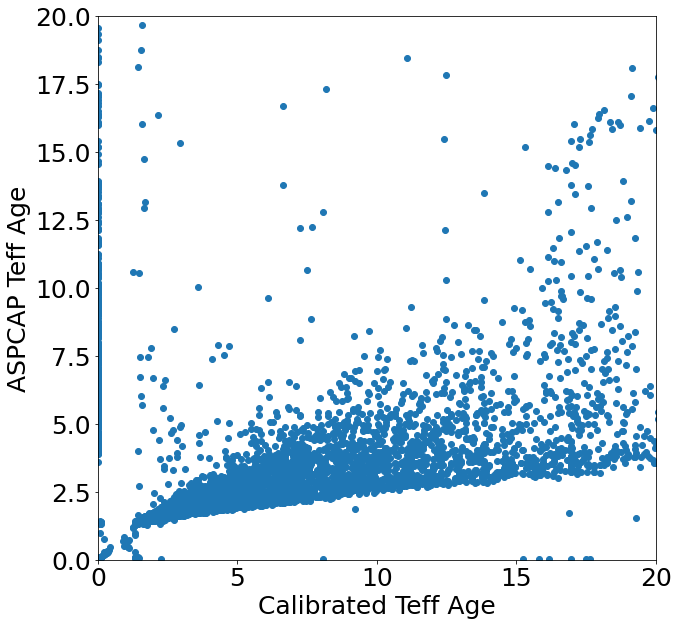

In [39]:
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE'],agetab_asp['AGE'])
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel(r'Calibrated Teff Age')
plt.ylabel(r'ASPCAP Teff Age')

Text(0, 0.5, 'ASPCAP Teff Age')

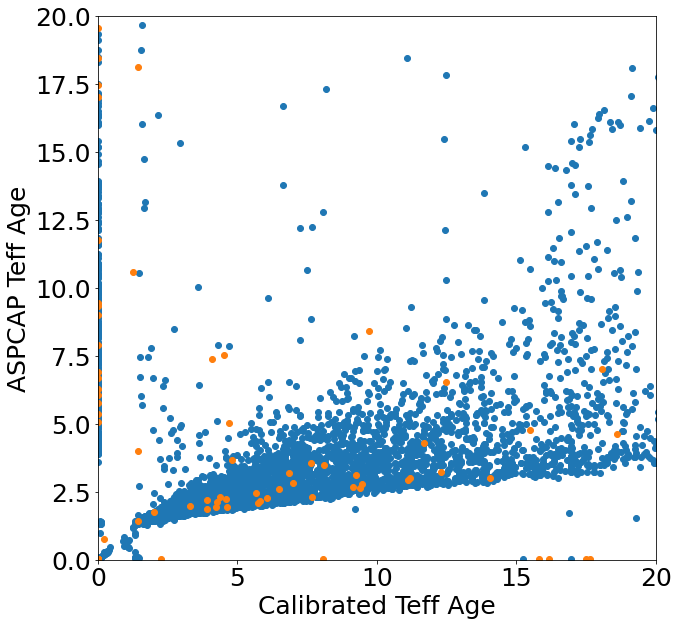

In [40]:
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE'][goodflags],agetab_asp['AGE'][goodflags])
plt.scatter(agetab['AGE'][badflags],agetab_asp['AGE'][badflags])
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel(r'Calibrated Teff Age')
plt.ylabel(r'ASPCAP Teff Age')

Text(0, 0.5, 'ASPCAP Teff Age')

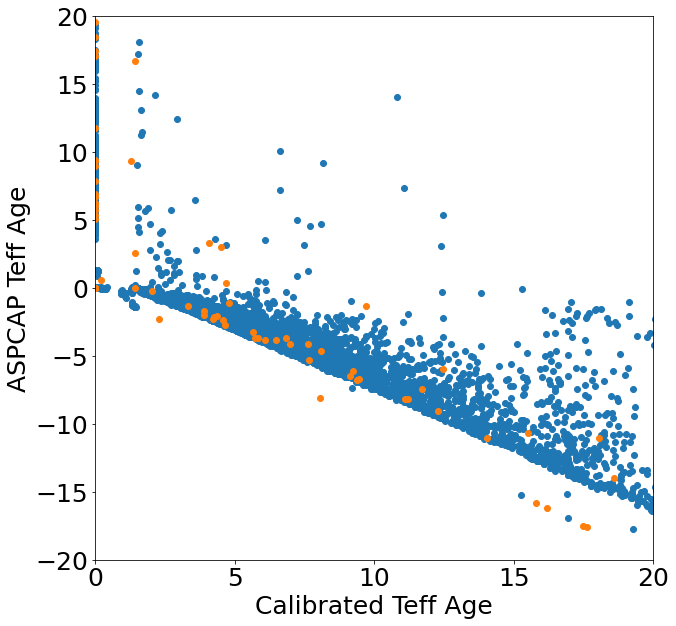

In [41]:
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE'][goodflags],agetab_asp['AGE'][goodflags]-agetab['AGE'][goodflags])
plt.scatter(agetab['AGE'][badflags],agetab_asp['AGE'][badflags]-agetab['AGE'][badflags])
plt.xlim(0,20)
plt.ylim(-20,20)
plt.xlabel(r'Calibrated Teff Age')
plt.ylabel(r'ASPCAP Teff Age')

In [42]:
len(np.squeeze(np.where(agetab_asp['AGE']==0.012)))

151

In [43]:
len(badflags)

158

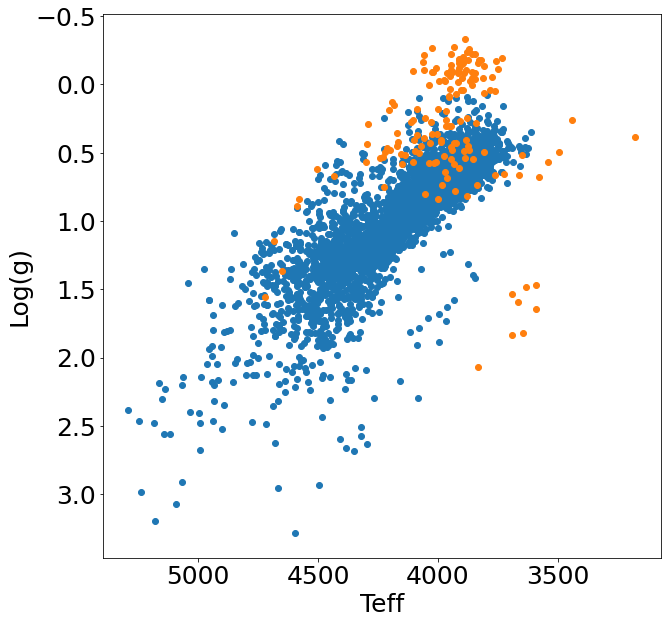

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(lmcdr17['TEFF'][goodflags],lmcdr17['LOGG'][goodflags])
plt.scatter(lmcdr17['TEFF'][badflags],lmcdr17['LOGG'][badflags])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.show()

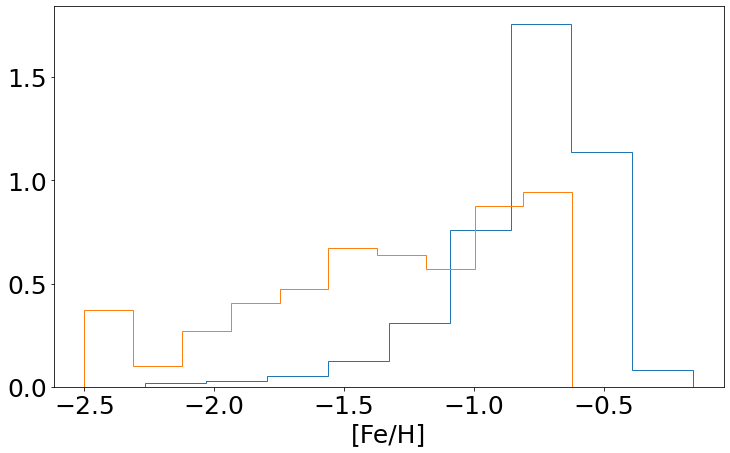

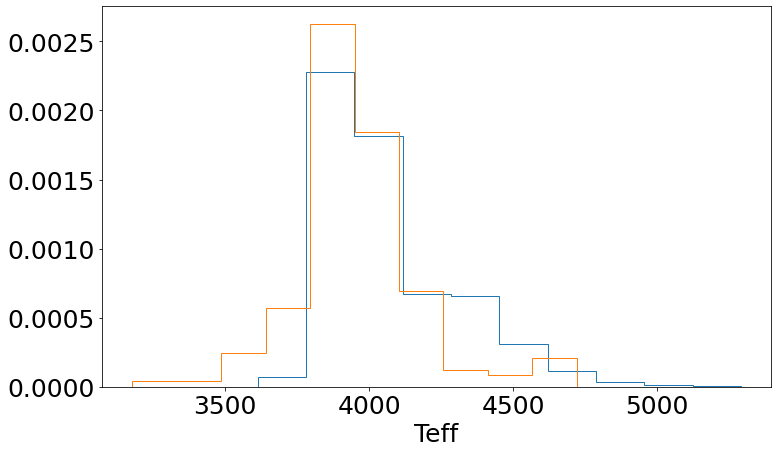

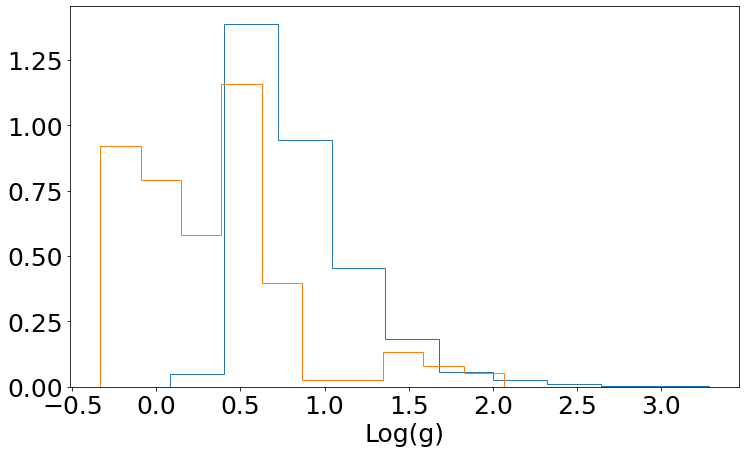

In [45]:
plt.figure(figsize=[12,7])
plt.hist(lmcdr17['FE_H'][goodflags],density=True,histtype='step')
plt.hist(lmcdr17['FE_H'][badflags],density=True,histtype='step')
plt.xlabel(r'[Fe/H]')
plt.show()

plt.figure(figsize=[12,7])
plt.hist(lmcdr17['TEFF'][goodflags],density=True,histtype='step')
plt.hist(lmcdr17['TEFF'][badflags],density=True,histtype='step')
plt.xlabel(r'Teff')
plt.show()

plt.figure(figsize=[12,7])
plt.hist(lmcdr17['LOGG'][goodflags],density=True,histtype='step')
plt.hist(lmcdr17['LOGG'][badflags],density=True,histtype='step')
plt.xlabel(r'Log(g)')
plt.show()


In [56]:
goodflags

array([   0,    1,    2, ..., 6127, 6128, 6129])

In [47]:
# lmcdr17['APOGEE_ID'][goodflags][star]

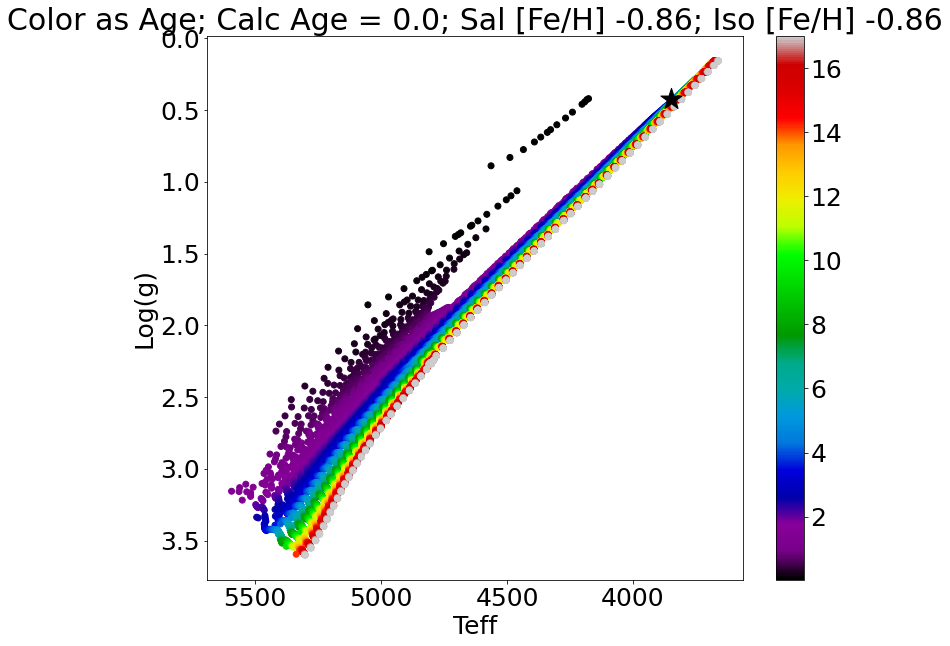

In [48]:
star = goodflags_badage[0][90]

star_gfba_iso = massive[np.where(massive['MH']==closest(massive['MH'],salfeh[goodflags][star]))]
star_gfba_iso_age = star_gfba_iso[np.where(star_gfba_iso['logAge']==closest(star_gfba_iso['logAge'],
                                                                        np.log10(agetab['AGE'][star]*10**9)))]

plt.figure(figsize=[12,10])
plt.scatter(10**star_gfba_iso['logTe'],star_gfba_iso['logg'],
            c=10**star_gfba_iso['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.scatter(lmcdr17['TEFF'][goodflags][star],lmcdr17['LOGG'][goodflags][star],
            c=agetab['AGE'][goodflags][star],cmap='nipy_spectral',
            marker='*',vmin=min(10**star_gfba_iso['logAge']/10**9),vmax=max(10**star_gfba_iso['logAge']/10**9),s=500)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age; Calc Age = {}; Sal [Fe/H] {:.2f}; Iso [Fe/H] {:.2f}'.format(agetab['AGE'][goodflags][star],
                                                               salfeh[goodflags][star],star_gfba_iso['MH'][0]))
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()


In [66]:
print(agetab['NAME'][goodflags[45]])

2M05200753-6945446


In [49]:
print(agetab['EXT'][goodflags][star])

[0.04583566 0.03762516 0.02897362 0.01289074 0.00816542 0.0051766 ]


In [50]:
from dlnpyutils import coords
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

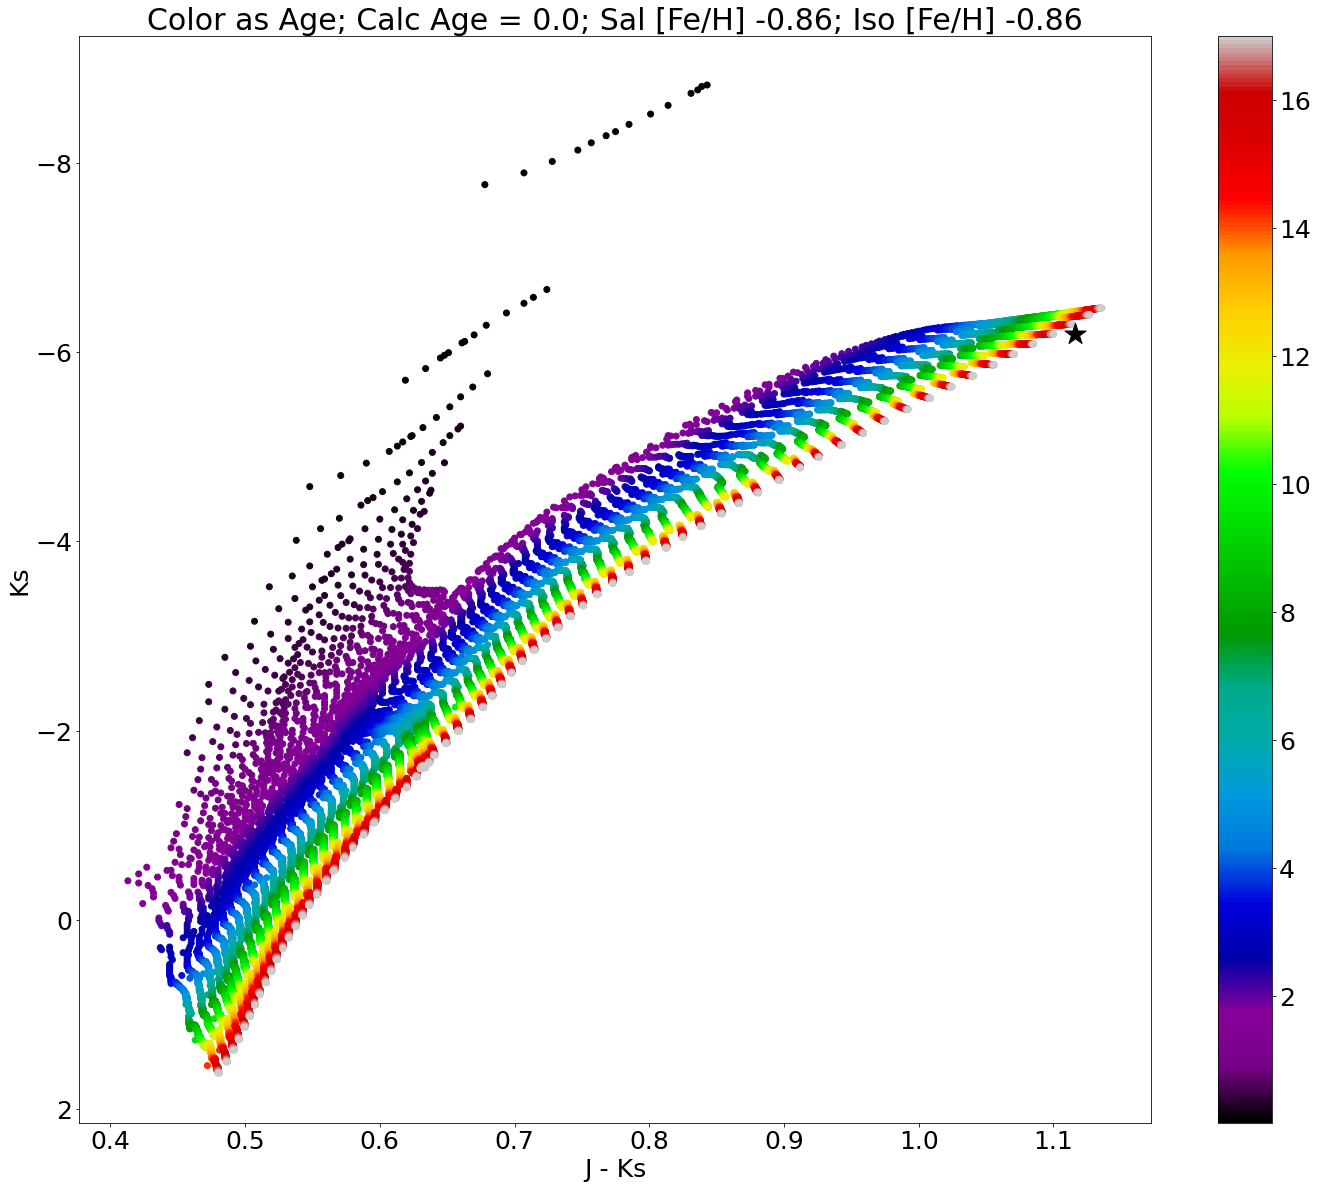

In [51]:
star_gfba_iso = massive[np.where(massive['MH']==closest(massive['MH'],salfeh[goodflags][star]))]
star_gfba_iso_age = star_gfba_iso[np.where(star_gfba_iso['logAge']==closest(star_gfba_iso['logAge'],
                                                                        np.log10(agetab['AGE'][star]*10**9)))]

ext = agetab['EXT'][goodflags][star][-1]
red = (extcoeff(leff['J'],rv=3.1,law='CCM89')-extcoeff(leff['K'],rv=3.1,law='CCM89'))*agetab['EXT'][goodflags][star][1]

plt.figure(figsize=[24,20])
plt.scatter(star_gfba_iso['Jmag']-star_gfba_iso['Ksmag'],star_gfba_iso['Ksmag'],
            c=10**star_gfba_iso['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.scatter((lmcdr17['J']-lmcdr17['K'])[goodflags][star]-red,
            lmcdr17['K'][goodflags][star]-5*np.log10(lmcdis[goodflags][star]*1000)+5-ext,
            c=agetab['AGE'][goodflags][star],cmap='nipy_spectral',
            marker='*',vmin=min(10**star_gfba_iso['logAge']/10**9),
            vmax=max(10**star_gfba_iso['logAge']/10**9),s=500)
plt.gca().invert_yaxis()
plt.title(r'Color as Age; Calc Age = {}; Sal [Fe/H] {:.2f}; Iso [Fe/H] {:.2f}'.format(agetab['AGE'][goodflags][star],
                                                               salfeh[goodflags][star],star_gfba_iso['MH'][0]))
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.show()

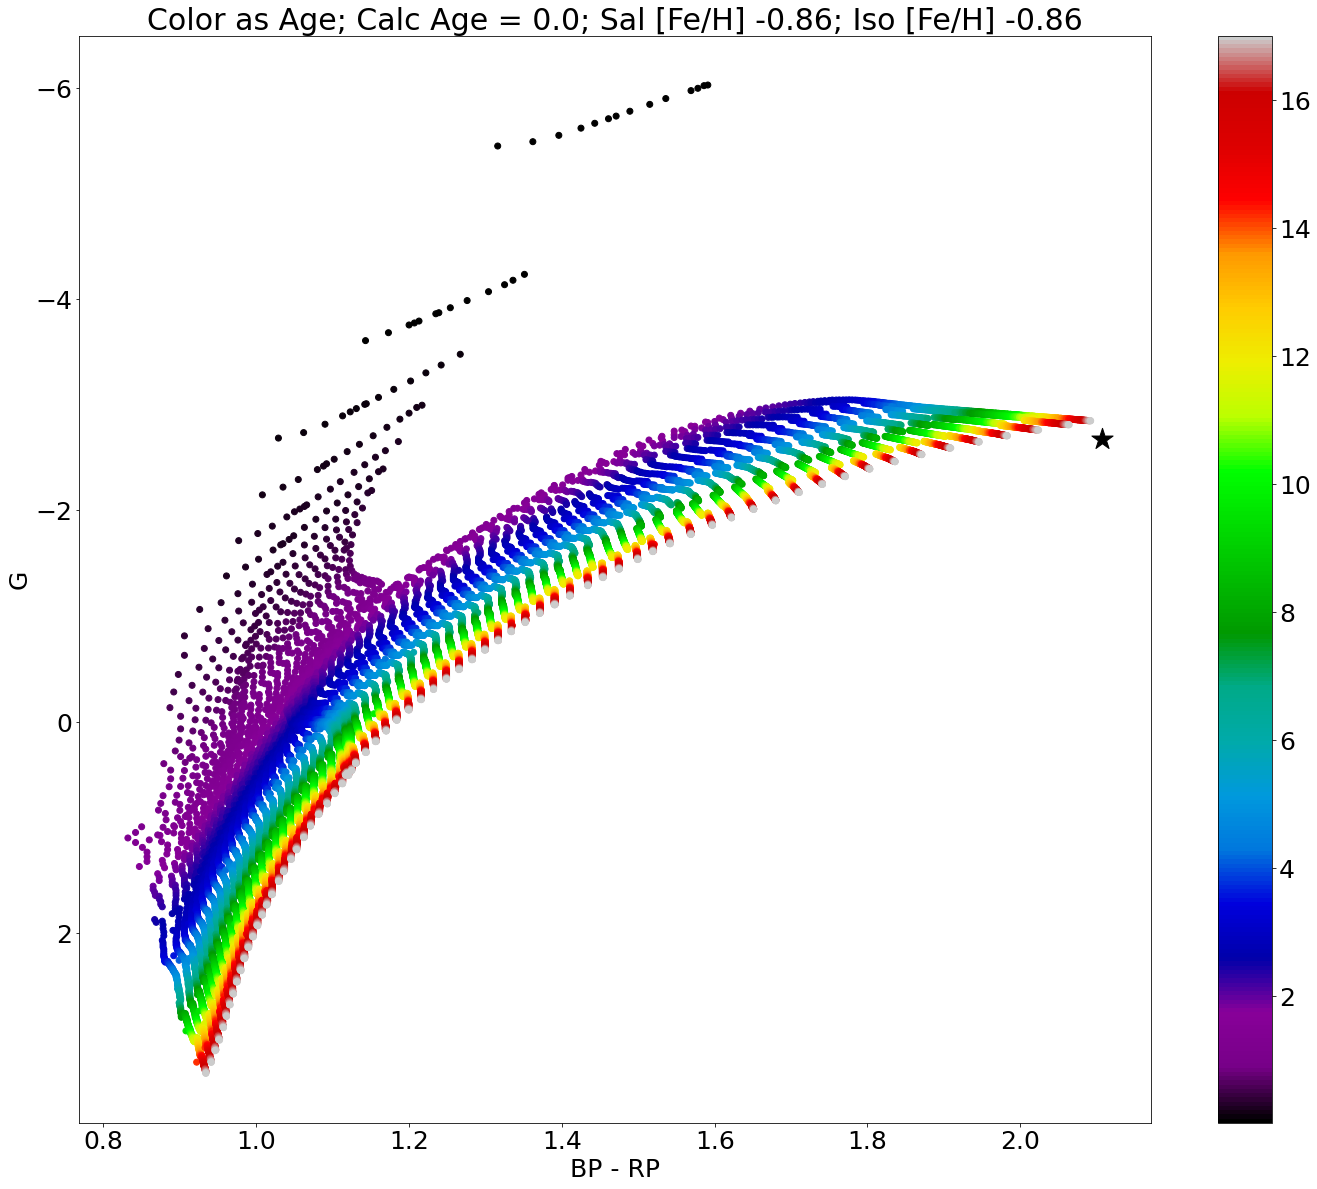

In [52]:
ext_gaia = agetab['EXT'][goodflags][star][1]
red_gaia = agetab['EXT'][goodflags][star][0]-agetab['EXT'][goodflags][star][2]

plt.figure(figsize=[24,20])
plt.scatter(star_gfba_iso['G_BPEDR3mag']-star_gfba_iso['G_RPEDR3mag'],star_gfba_iso['GEDR3mag'],
            c=10**star_gfba_iso['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.scatter((lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])[goodflags][star]-red_gaia,
            lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][goodflags][star]-5*np.log10(lmcdis[goodflags][star]*1000)+5-ext_gaia,
            c=agetab['AGE'][goodflags][star],cmap='nipy_spectral',
            marker='*',vmin=min(10**star_gfba_iso['logAge']/10**9),
            vmax=max(10**star_gfba_iso['logAge']/10**9),s=500)
plt.gca().invert_yaxis()
plt.title(r'Color as Age; Calc Age = {}; Sal [Fe/H] {:.2f}; Iso [Fe/H] {:.2f}'.format(agetab['AGE'][goodflags][star],
                                                               salfeh[goodflags][star],star_gfba_iso['MH'][0]))
plt.xlabel(r'BP - RP')
plt.ylabel(r'G')
plt.show()

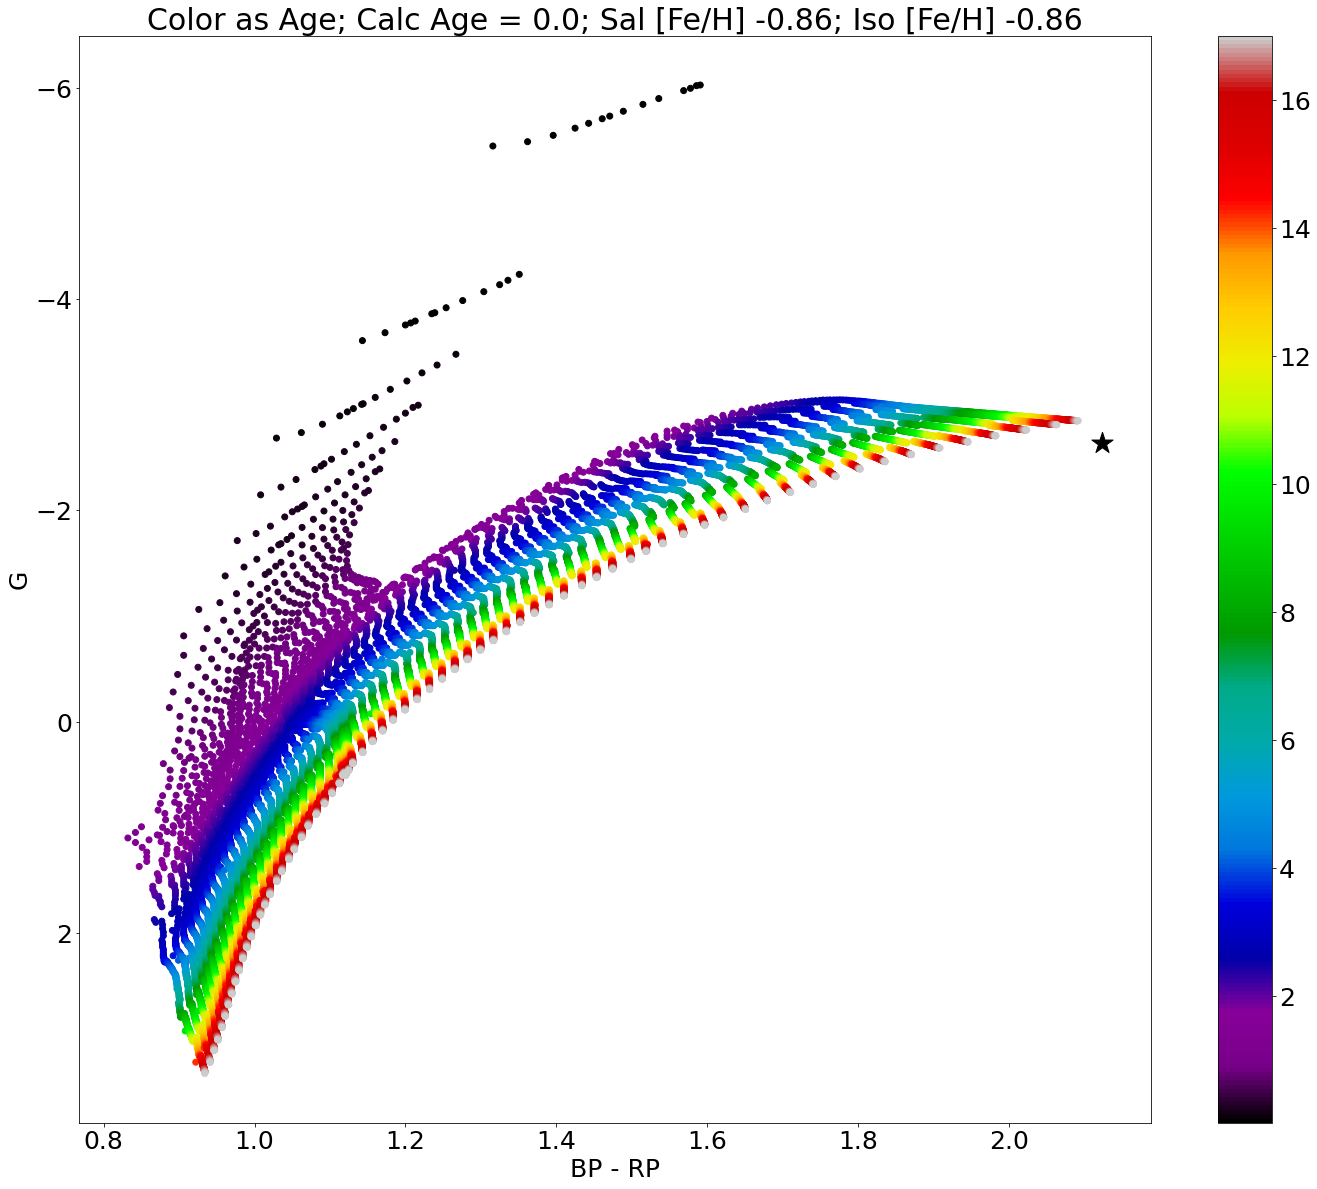

In [53]:
plt.figure(figsize=[24,20])
plt.scatter(star_gfba_iso['G_BPEDR3mag']-star_gfba_iso['G_RPEDR3mag'],star_gfba_iso['GEDR3mag'],
            c=10**star_gfba_iso['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.scatter((lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])[goodflags][star],
            lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][goodflags][star]-5*np.log10(lmcdis[goodflags][star]*1000)+5,
            c=agetab['AGE'][goodflags][star],cmap='nipy_spectral',
            marker='*',vmin=min(10**star_gfba_iso['logAge']/10**9),
            vmax=max(10**star_gfba_iso['logAge']/10**9),s=500)
plt.gca().invert_yaxis()
plt.title(r'Color as Age; Calc Age = {}; Sal [Fe/H] {:.2f}; Iso [Fe/H] {:.2f}'.format(agetab['AGE'][goodflags][star],
                                                               salfeh[goodflags][star],star_gfba_iso['MH'][0]))
plt.xlabel(r'BP - RP')
plt.ylabel(r'G')
plt.show()

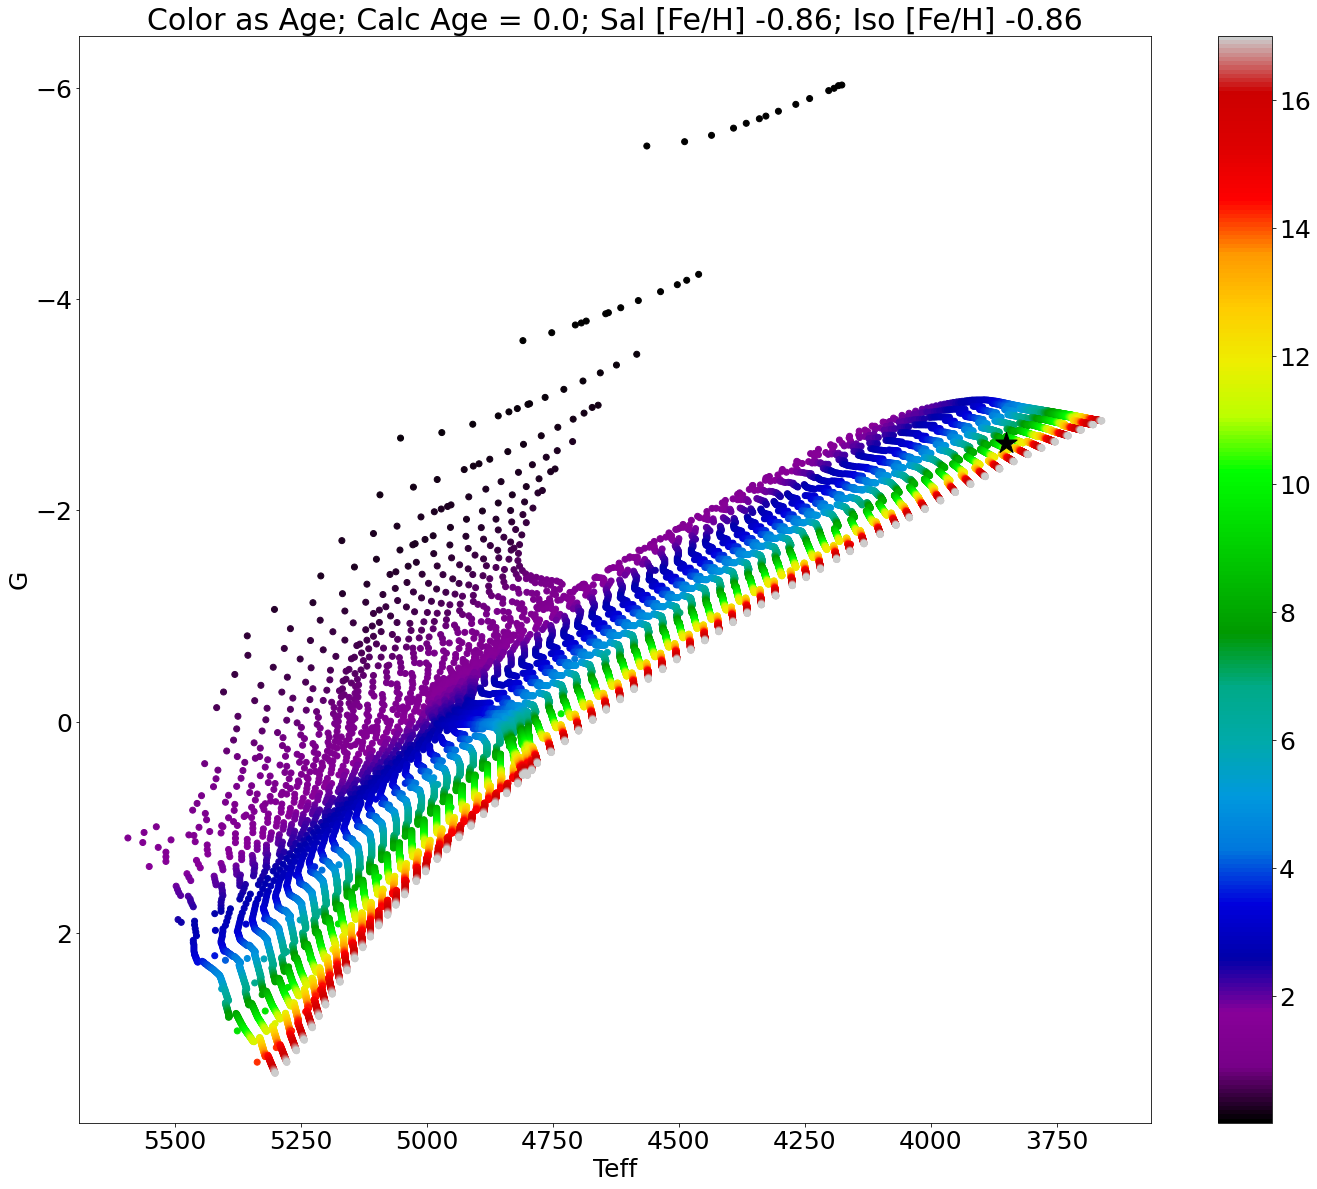

In [54]:
plt.figure(figsize=[24,20])
plt.scatter(10**star_gfba_iso['logTe'],star_gfba_iso['GEDR3mag'],
            c=10**star_gfba_iso['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.scatter(lmcdr17['TEFF'][goodflags][star],
            lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][goodflags][star]-5*np.log10(lmcdis[goodflags][star]*1000)+5,
            c=agetab['AGE'][goodflags][star],cmap='nipy_spectral',
            marker='*',vmin=min(10**star_gfba_iso['logAge']/10**9),
            vmax=max(10**star_gfba_iso['logAge']/10**9),s=500)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(r'Color as Age; Calc Age = {}; Sal [Fe/H] {:.2f}; Iso [Fe/H] {:.2f}'.format(agetab['AGE'][goodflags][star],
                                                               salfeh[goodflags][star],star_gfba_iso['MH'][0]))
plt.xlabel(r'Teff')
plt.ylabel(r'G')
plt.show()